In [1]:
# evaluate_tabnet.py
import pandas as pd
import numpy as np
import joblib
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from pytorch_tabnet.tab_model import TabNetRegressor

In [2]:
# 1) Load cleaned transaction data
df = pd.read_csv("../data/transactions_clean.csv", parse_dates=["InvoiceDate"])
print("✅ Loaded cleaned data:", df.shape)

✅ Loaded cleaned data: (779495, 10)


In [3]:

# 2) Feature engineering (must match train_tabnet.py)
df["hour"]        = df["InvoiceDate"].dt.hour
df["day_of_week"] = df["InvoiceDate"].dt.dayofweek
df["month"]       = df["InvoiceDate"].dt.month

In [4]:
# 3) Define features & target
categorical_cols = ["StockCode", "Country"]
numerical_cols   = ["Quantity", "Price", "hour", "day_of_week", "month"]
features         = categorical_cols + numerical_cols
target           = "TotalPrice"

In [5]:
# 4) Build X, y (no encoding yet)
X = df[features]
y = df[target].values.reshape(-1, 1)

# 5) Split into train/test so test only contains seen categories
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print(f"✅ Split data → train: {X_train.shape}, test: {X_test.shape}")




✅ Split data → train: (623596, 7), test: (155899, 7)


In [6]:
# 6) Apply OrdinalEncoder with handling for unknown values on categorical columns
# Ensure the categorical columns are treated as strings
X_train[categorical_cols] = X_train[categorical_cols].astype(str)
X_test[categorical_cols] = X_test[categorical_cols].astype(str)

# Initialize and fit the encoder on training data only
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
encoder.fit(X_train[categorical_cols])

# Transform both train and test data
X_train[categorical_cols] = encoder.transform(X_train[categorical_cols])
X_test[categorical_cols] = encoder.transform(X_test[categorical_cols])
print("✅ Applied OrdinalEncoder with handle_unknown for:", categorical_cols)


✅ Applied OrdinalEncoder with handle_unknown for: ['StockCode', 'Country']


In [7]:

# 7) Convert DataFrames to numpy arrays before scaling/model
X_train = X_train.values
X_test  = X_test.values

In [8]:
# 8) Load the saved StandardScaler and apply it to numerical features
num_start = len(categorical_cols)  # numerical columns start after categorical ones

# Instead of fitting a new scaler, load the one saved during training
scaler = joblib.load("../models/scaler_num.pkl")
X_test[:, num_start:] = scaler.transform(X_test[:, num_start:])
print("✅ Scaled numerical features with saved scaler")

✅ Scaled numerical features with saved scaler


In [9]:
# 9) Load the fine‑tuned TabNet model
reg = TabNetRegressor()
reg.load_model("../models/tabnet_regressor.zip")  # Note: fixed the filename
print("✅ TabNet model loaded")

✅ TabNet model loaded


c:\Users\hp\Innovative-ml-project\NEW-ML-PROJECT\.venv\Lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


In [10]:
# 10) Predict & evaluate
y_pred = reg.predict(X_test)

# Flatten the arrays in case they are (n, 1)
y_test_flat = y_test.flatten()
y_pred_flat = y_pred.flatten()

rmse = np.sqrt(mean_squared_error(y_test_flat, y_pred_flat))
print(f"\n🎯 Test RMSE: {rmse:.4f}")


🎯 Test RMSE: 68.7095


In [13]:
import datetime

# Log RMSE to a log file
with open("../reports/eval_log.txt", "a") as f:
    log_time = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    f.write(f"[{log_time}] TabNet RMSE: {rmse:.4f}\n")

print("📝 Logged evaluation RMSE to ../reports/eval_log.txt")


📝 Logged evaluation RMSE to ../reports/eval_log.txt


In [12]:
# Save predictions and actuals to a CSV
pred_df = pd.DataFrame({
    "Actual": y_test_flat,
    "Predicted": y_pred_flat
})

pred_df.to_csv("../reports/tabnet_predictions.csv", index=False)
print("📁 Saved predictions to ../reports/tabnet_predictions.csv")


📁 Saved predictions to ../reports/tabnet_predictions.csv


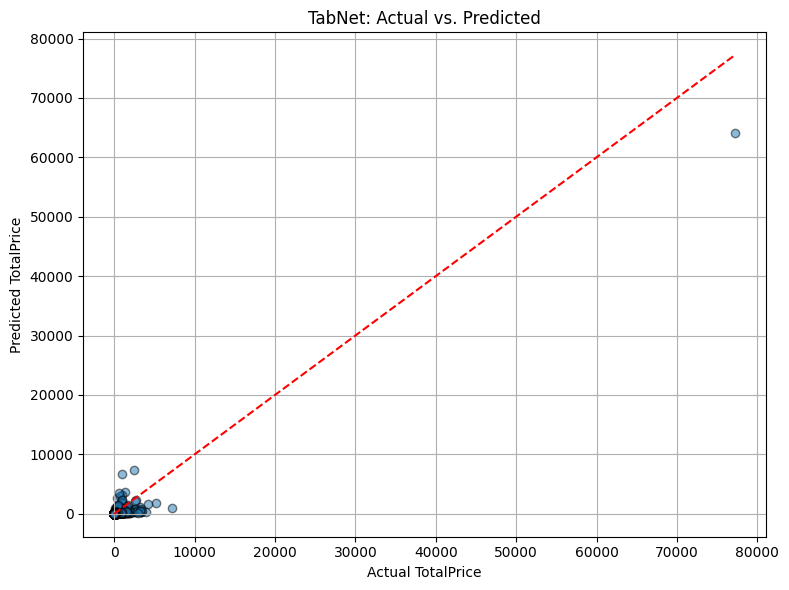

📊 Prediction plot saved to ../reports/tabnet_pred_plot.png


In [14]:
import matplotlib.pyplot as plt

# Scatter plot of actual vs predicted
plt.figure(figsize=(8, 6))
plt.scatter(y_test_flat, y_pred_flat, alpha=0.5, edgecolor='k')
plt.plot([y_test_flat.min(), y_test_flat.max()],
         [y_test_flat.min(), y_test_flat.max()], 'r--')
plt.xlabel("Actual TotalPrice")
plt.ylabel("Predicted TotalPrice")
plt.title("TabNet: Actual vs. Predicted")
plt.grid(True)
plt.tight_layout()
plt.savefig("../reports/tabnet_pred_plot.png")
plt.show()

print("📊 Prediction plot saved to ../reports/tabnet_pred_plot.png")


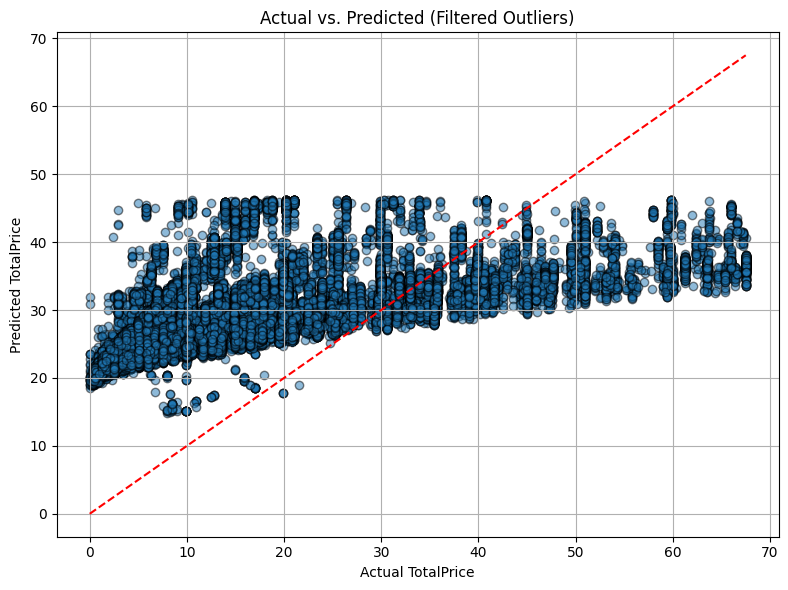

📊 Filtered prediction plot saved to ../reports/tabnet_pred_plot_filtered.png


In [23]:
# Filter out the top 5% extreme values
threshold_actual = np.percentile(y_test_flat, 95)
threshold_pred = np.percentile(y_pred_flat, 95)

mask = (y_test_flat <= threshold_actual) & (y_pred_flat <= threshold_pred)

plt.figure(figsize=(8, 6))
plt.scatter(y_test_flat[mask], y_pred_flat[mask], alpha=0.5, edgecolor='k')
plt.plot([y_test_flat[mask].min(), y_test_flat[mask].max()],
         [y_test_flat[mask].min(), y_test_flat[mask].max()], 'r--')
plt.xlabel("Actual TotalPrice")
plt.ylabel("Predicted TotalPrice")
plt.title("Actual vs. Predicted (Filtered Outliers)")
plt.grid(True)
plt.tight_layout()
plt.savefig("../reports/tabnet_pred_plot_filtered.png")
plt.show()

print("📊 Filtered prediction plot saved to ../reports/tabnet_pred_plot_filtered.png")
